In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Используются экспериментальные данные создания регрессионных моделей энергопотребления бытовой техники в здании с низким энергопотреблением.<br>
Ссылка на датасет [Kaggle](https://www.kaggle.com/datasets/sohommajumder21/appliances-energy-prediction-data-set/data)

In [2]:
data = pd.read_csv("./energydata_complete.csv", index_col=['date'])

In [3]:
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 11-01-2016 17:00 to 27-05-2016 18:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 non-nu

Датасет не имеет пустых значений

In [5]:
# Колонки 'rv1' и 'rv2' - просто шум. Можно их дропнуть
data.drop(['rv1', 'rv2'], axis=1, inplace=True)

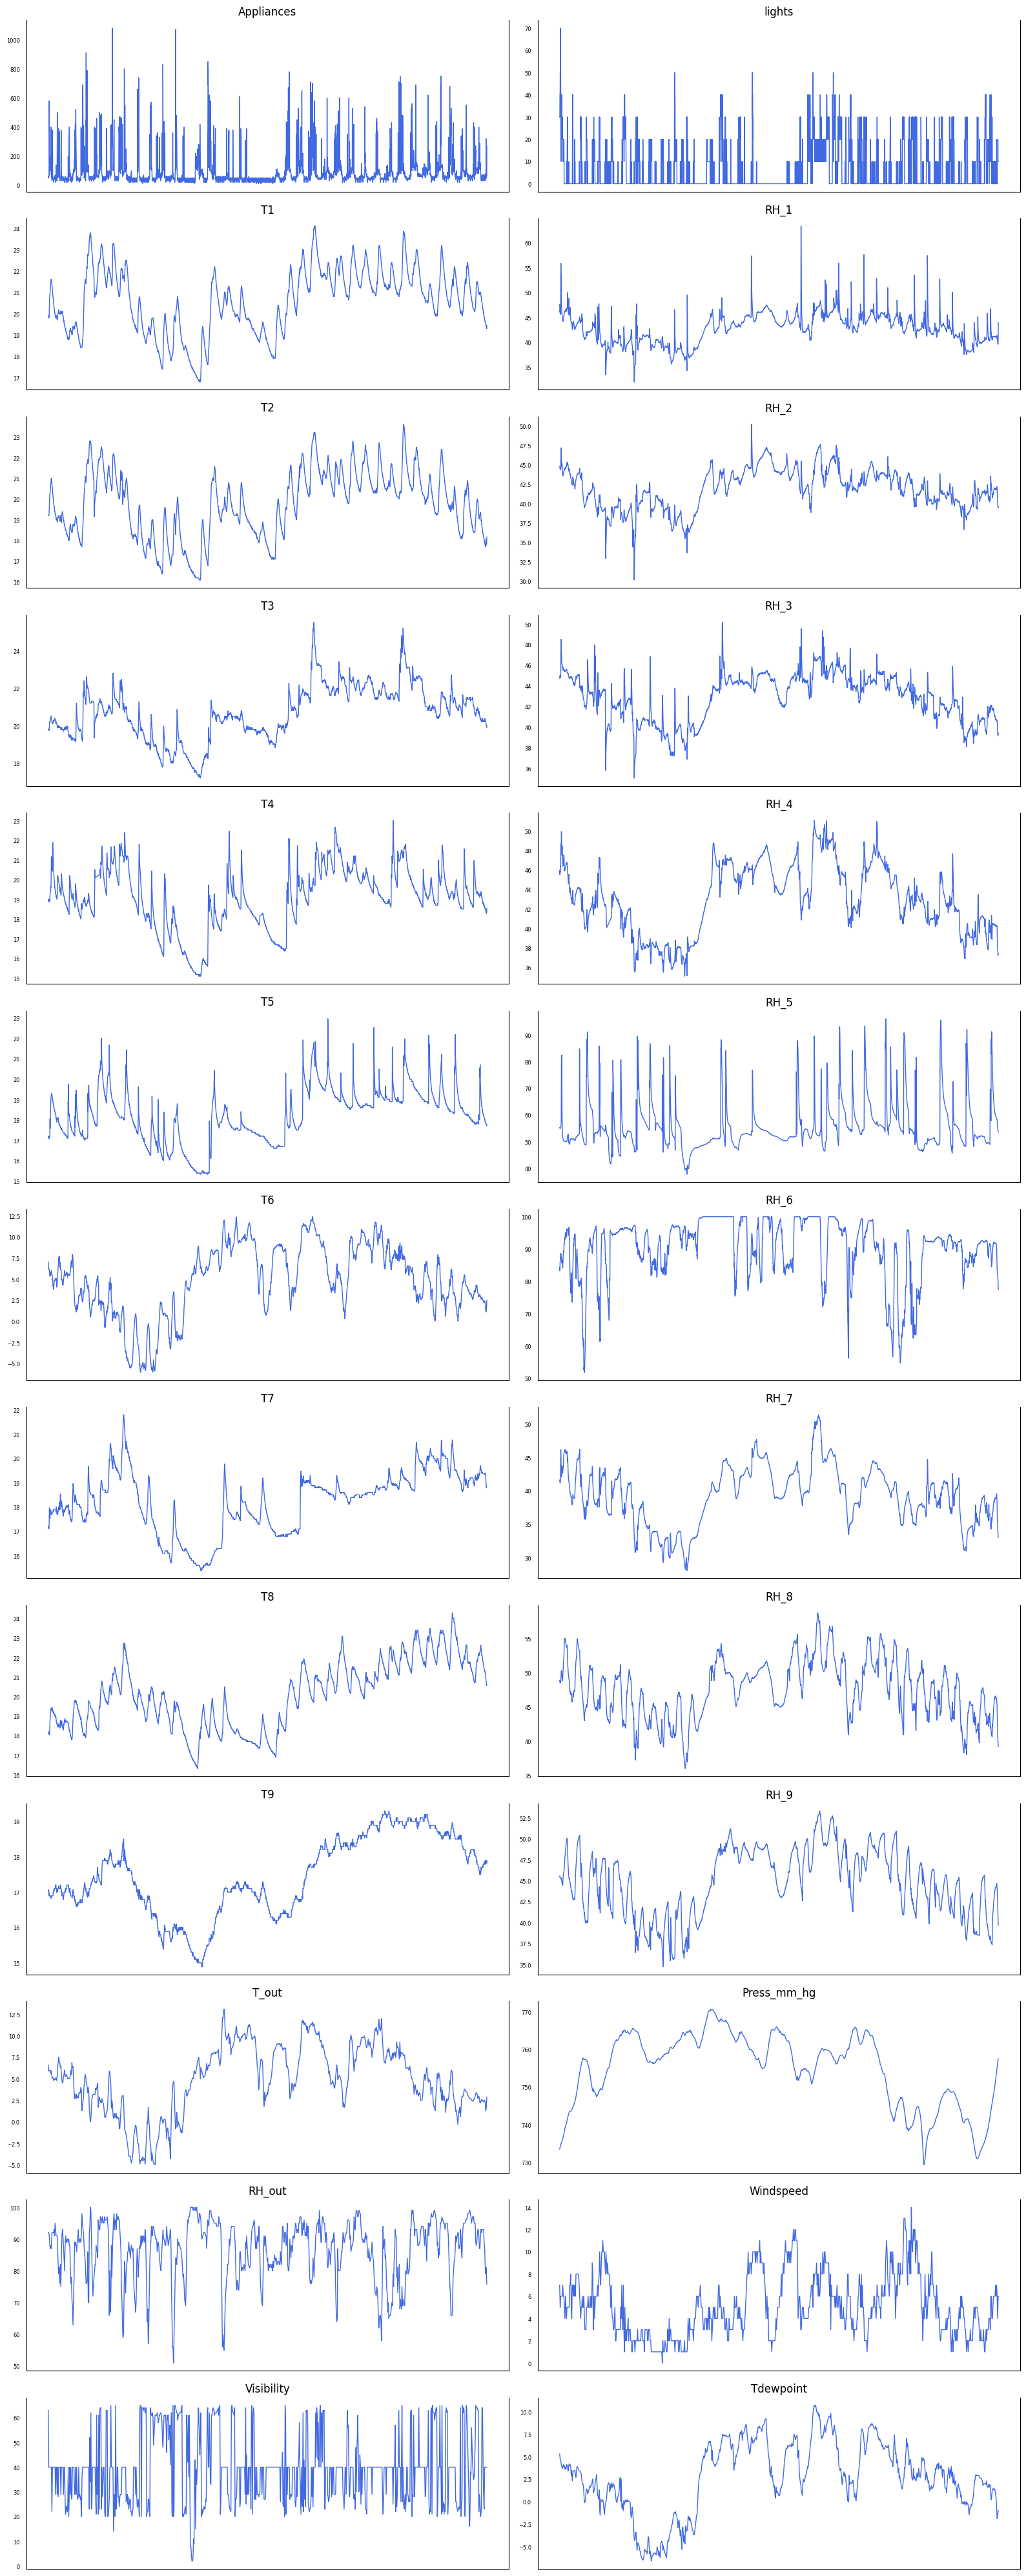

In [16]:
max_to_show = 5000

fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(16, 40))
for i, ax in enumerate(axes.flatten()):
    ax.plot(data[data.columns[i]][:max_to_show], color='royalblue', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.xaxis.set_ticklabels([])

plt.tight_layout()

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests

# Тест Грэнджера на причинность
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=12, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
grangers_causation_matrix(data, variables=data.columns, maxlag=20) 

,Appliances_x,lights_x,T1_x,RH_1_x,T2_x,RH_2_x,T3_x,RH_3_x,T4_x,RH_4_x,...,T8_x,RH_8_x,T9_x,RH_9_x,T_out_x,Press_mm_hg_x,RH_out_x,Windspeed_x,Visibility_x,Tdewpoint_x
Appliances_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0131,0.0064,...,0.0000,0.0000,0.2730,0.0000,0.0000,0.0002,0.0000,0.0000,0.3620,0.0017
lights_y,0.0000,1.0000,0.0000,0.0000,0.0391,0.0131,0.0000,0.0000,0.0011,0.0000,...,0.0000,0.0001,0.0000,0.0000,0.0012,0.0000,0.0084,0.0009,0.4103,0.0096
T1_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.1964,0.0000,0.0000,0.0002,0.0000
RH_1_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.1102,0.0000,...,0.0001,0.0000,0.1525,0.0000,0.0000,0.0000,0.0000,0.0063,0.5516,0.0000
T2_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0001,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,0.0005,0.0805,0.0000
RH_2_y,0.0000,0.0009,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1010,0.0000
T3_y,0.0000,0.0097,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0025,...,0.0000,0.0185,0.0000,0.1739,0.0000,0.3091,0.0000,0.0001,0.8262,0.0000
RH_3_y,0.0000,0.0000,0.0000,0.0000,0.0021,0.0000,0.0000,1.0000,0.2452,0.0000,...,0.1256,0.0000,0.0912,0.0000,0.0000,0.0778,0.0000,0.0142,0.5593,0.0000
T4_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6805,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0015,0.1048,0.0000
RH_4_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0906,0.0000,0.0000,1.0000,...,0.1078,0.0000,0.0095,0.0000,0.0000,0.0000,0.0000,0.0007,0.1113,0.0000


In [77]:
df = data[['Appliances', 'T9', 'Visibility', 'Tdewpoint']]

In [20]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Тест на коинтегральность 
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)    

In [79]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Appliances ::  1510.34   > 40.1749   =>   True
T9     ::  438.27    > 24.2761   =>   True
Visibility ::  31.26     > 12.3212   =>   True
Tdewpoint ::  0.66      > 4.1296    =>   False


In [66]:
# Выбираем значимые колонки

# df = data.drop(columns=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'Visibility', 'Tdewpoint', 'lights'])

In [67]:
from statsmodels.tsa.stattools import adfuller

# Стационарность
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [80]:
train_part = int(0.8*(len(df)))

train = df[:train_part]
test = df[train_part:]

In [81]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Appliances" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.0101
 No. Lags Chosen       = 13
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "T9" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.937
 No. Lags Chosen       = 11
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.3148. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Visibility" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

Все ряды стационарны

In [84]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(df)
x = model.select_order(maxlags=100)
x.summary()

,AIC,BIC,FPE,HQIC
0,18.04,18.04,6.842e+07,18.04
1,-0.4705,-0.4624,0.6247,-0.4678
2,-2.645,-2.631,0.07100,-2.640
3,-2.671,-2.651,0.06915,-2.665
4,-2.698,-2.671,0.06731,-2.689
5,-2.735,-2.701,0.06491,-2.724
6,-2.780,-2.739,0.06207,-2.766
7,-2.849,-2.803,0.05789,-2.834
8,-3.288,-3.235,0.03733,-3.271
9,-3.300,-3.240,0.03690,-3.280


Выбираем лаг 38

In [89]:
lags = 98

model_fitted = model.fit(lags)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Dec, 2023
Time:                     16:24:16
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -3.27190
Nobs:                     19637.0    HQIC:                  -3.69643
Log likelihood:          -71559.9    FPE:                  0.0201790
AIC:                     -3.90313    Det(Omega_mle):       0.0186413
--------------------------------------------------------------------
Results for equation Appliances
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 18.544639         7.224640            2.567           0.010
L1.Appliances          0.783583         0.007210          108.686           0.000
L1.T9                 -5.248075        11.074888   

In [86]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
    
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Appliances : 2.0
T9 : 2.0
Visibility : 2.0
Tdewpoint : 2.0


In [90]:
forecast_input = df.values[-lags:]
forecast_input

array([[ 60.        ,  22.7       ,  62.        ,  10.9       ],
       [ 40.        ,  22.7       ,  62.        ,  10.9       ],
       [ 60.        ,  22.7       ,  61.83333333,  10.9       ],
       [ 40.        ,  22.7       ,  61.66666667,  10.9       ],
       [ 60.        ,  22.7       ,  61.5       ,  10.9       ],
       [ 50.        ,  22.7       ,  61.33333333,  11.        ],
       [ 50.        ,  22.7       ,  61.16666667,  11.        ],
       [ 60.        ,  22.7       ,  61.        ,  11.        ],
       [ 60.        ,  22.7       ,  59.66666667,  11.1       ],
       [ 60.        ,  22.7       ,  58.33333333,  11.1       ],
       [ 60.        ,  22.7       ,  57.        ,  11.2       ],
       [ 50.        ,  22.7       ,  55.66666667,  11.3       ],
       [ 60.        ,  22.7       ,  54.33333333,  11.3       ],
       [ 60.        ,  22.7       ,  53.        ,  11.4       ],
       [ 60.        ,  22.7       ,  51.66666667,  11.4       ],
       [ 60.        ,  22

In [91]:
# Forecast
nobs = 100 # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Appliances_2d,T9_2d,Visibility_2d,Tdewpoint_2d
date,,,,
27-05-2016 01:30,324.282147,23.202007,26.748436,13.190124
27-05-2016 01:40,258.912007,23.203331,26.703232,13.206190
27-05-2016 01:50,233.979003,23.207448,27.052768,13.226238
27-05-2016 02:00,212.923331,23.207302,27.584325,13.246171
27-05-2016 02:10,211.110627,23.197906,28.342341,13.262565
...,...,...,...,...
27-05-2016 17:20,98.114946,23.439034,35.973777,11.684274
27-05-2016 17:30,98.657687,23.445889,35.961519,11.676811
27-05-2016 17:40,101.033249,23.451032,35.954676,11.665142


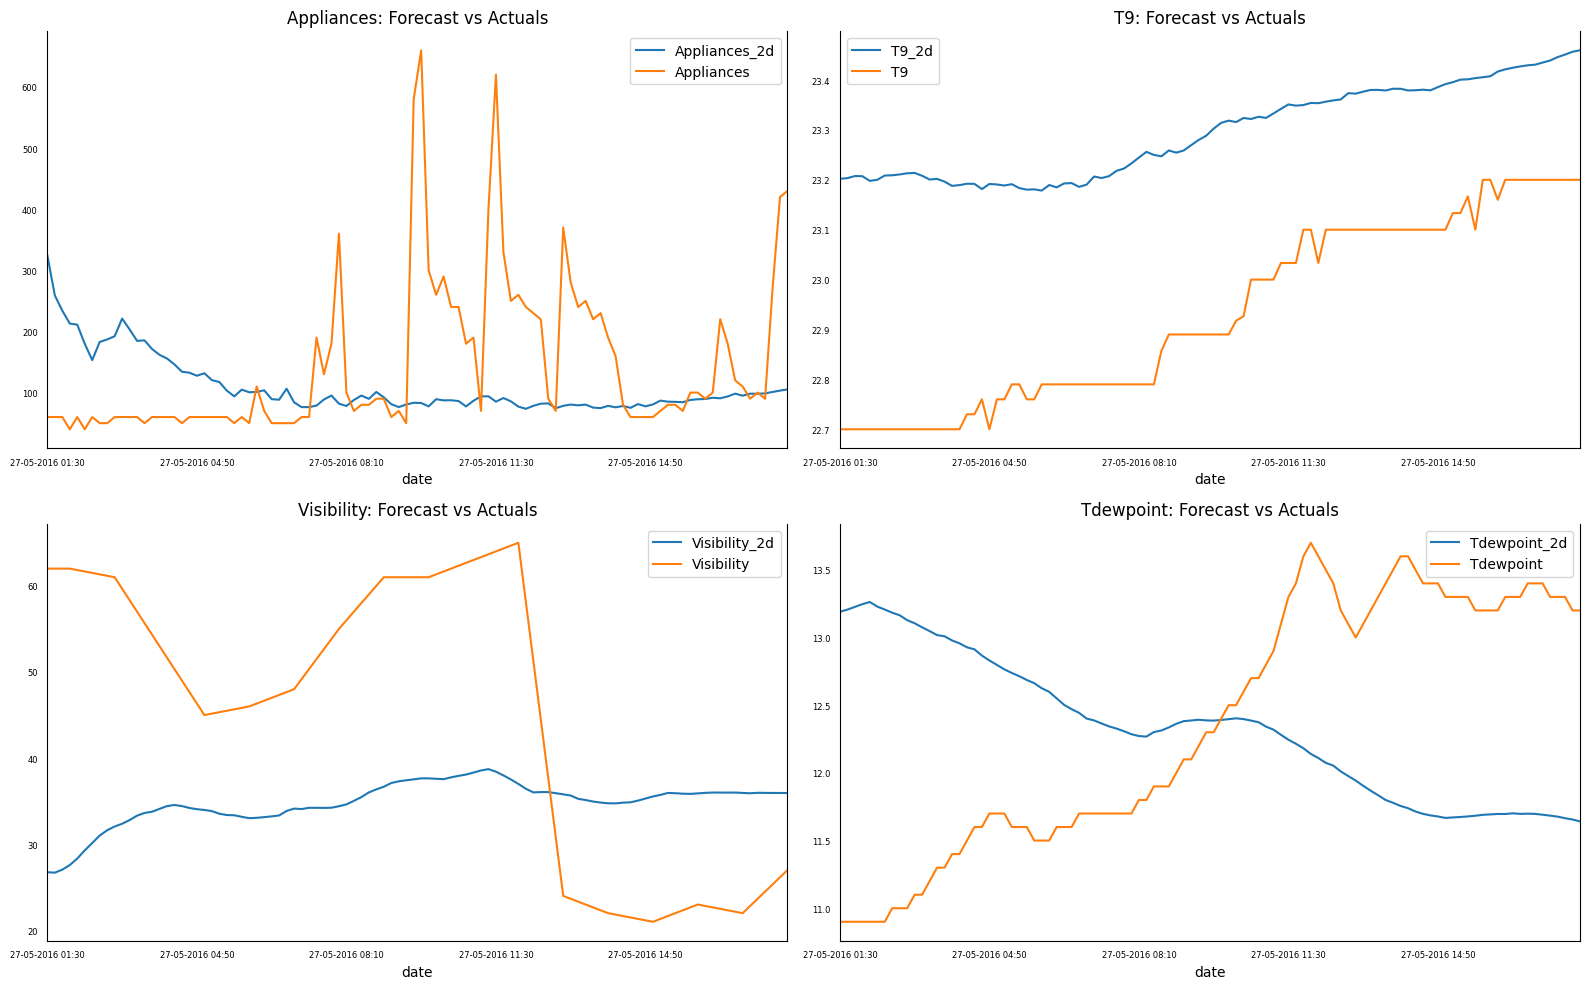

In [93]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, figsize=(16,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col+"_2d"].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();